This notebook is a colab version for DL lab 2 based om "lab-2-Breast-Cancer-Histopathology-SeNet.ipynb", compatible for working in Google Drive. In order to use it from Google Drive, please make sure you perfrmed the below steps:

**Please open this notebook on the applied-dl-2018 folder after yout cloned it - you can do it "File -> Save a copy in Drive"**
# **Prerequisits**

1.   *git clone "applied-dl-2018" repository to your own google Drive client.*     (git clone https://github.com/bayesianio/applied-dl-2018.git)
2.   *Navigate to "applied-dl-2018" and create a folder named "db", navigate to it and create another folder named "data"*.
3.   *Download the data from  http://andrewjanowczyk.com/wp-static/IDC_regular_ps50_idx5.zip. This is 1.5GB, so you might want to upload to Google Drive only a subset of the data.* 
4.   Unzipe the file and upload the folder with the same name ("IDC_regular_ps50_idx5") to your Drive, under .\db\data\.




 **Install packages**

In [0]:
# Download Torch and other dependancies
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install tqdm
!pip3 install PIL
!pip install image

    90% |█████████████████████████████   | 536.4MB 40.6MB/s eta 0:00:02

    100% |████████████████████████████████| 592.3MB 10.0MB/s 
    100% |████████████████████████████████| 51kB 1.5MB/s 
    100% |████████████████████████████████| 2.0MB 575kB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 51kB 2.8MB/s 
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
    100% |████████████████████████████████| 7.1MB 188kB/s 


**Uninstall pillow and reinstall it as a workaround**

In [0]:
# uninstall pillow and reinstall an earlier versoin again
!pip uninstall -y pillow
!CC="cc -mavx2" pip install -U --force-reinstall pillow-simd

Uninstalling Pillow-5.1.0:
  Successfully uninstalled Pillow-5.1.0
    100% |████████████████████████████████| 14.2MB 91kB/s 
  Running setup.py bdist_wheel for pillow-simd ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/58/45/cf/aaf3e1db66c24e3350e3a2ad9bd6dfbd574ede6d613ba321bf
Successfully built pillow-simd


In [0]:
# Check PIL
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import torchvision
from PIL import Image, ImageDraw
# from tensorboardX import SummaryWriter

In [0]:
#seed and cuda
%reset -f 
%matplotlib inline

import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random 


import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

use_cuda = torch.cuda.is_available()
# use_cuda = False

print("USE CUDA=" + str (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

manualSeed = None
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if manualSeed is None:
        manualSeed = 999
fixSeed(manualSeed)

__Python VERSION: 3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]
__pyTorch VERSION: 0.3.0.post4
__CUDA VERSION
/bin/sh: 1: nvcc: not found
__CUDNN VERSION: 7003
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
USE CUDA=True


In [0]:
# import PIL - drive workaround
#Workaround for PIL 5.0 in Google Colab,
#http://forums.fast.ai/t/attributeerror-module-pil-image-has-no-attribute-register-extensions/106   89/18
import PIL
def register_extension(id, extension):
  PIL.Image.EXTENSION[extension.lower()] = id.upper()
  PIL.Image.register_extension = register_extension
def register_extensions(id, extensions):
  for extension in extensions:
    register_extension(id, extension)
PIL.Image.register_extensions = register_extensions

In [0]:
# datasets

import os
import os, sys, pdb, shutil, time, random
import argparse
import torch
import torch.backends.cudnn as cudnn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random
import sys

class GenericDataset(Dataset):
  def __init__(self, labels, root_dir, subset=False, transform=None):
    self.labels = labels
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    img_name = self.labels.iloc[idx, 0]  # file name
    fullname = join(self.root_dir, img_name)
    image = Image.open(fullname).convert('RGB')
    labels = self.labels.iloc[idx, 2]  # category_id
    #         print (labels)
    if self.transform:
      image = self.transform(image)
    return image, labels

  @staticmethod
  def find_classes(fullDir):
    classes = [d for d in os.listdir(fullDir) if os.path.isdir(os.path.join(fullDir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    num_to_class = dict(zip(range(len(classes)), classes))

    train = []
    for index, label in enumerate(classes):
      path = fullDir + label + '/'
      for file in listdir(path):
        train.append(['{}/{}'.format(label, file), label, index])

    df = pd.DataFrame(train, columns=['file', 'category', 'category_id', ])

    return classes, class_to_idx, num_to_class, df




** Connect colab to Google Drive **

In [0]:
# connect to drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# check location
!pwd
!ls

/content
datalab


In [0]:
# link the folder to Drive
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# navigate to drive
%cd drive
!pwd

/content/drive
/content/drive


In [0]:
# navigate to DL lab folder
%cd applied-dl-2018
!pwd

/content/drive/applied-dl-2018
/content/drive/applied-dl-2018


**Define Custom Dataset **

In [0]:
# generate dataset folder containing the data
from kmodels import *
from kdataset import *
import os
from glob import glob
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

dataset='IDC_regular_ps50_idx5'
data_dir= '/content/drive/applied-dl-2018/db/data/' +  dataset

**Print single image**

Number of images: 12443
/content/drive/applied-dl-2018/db/data/IDC_regular_ps50_idx5/8984/0/8984_idx5_x1101_y1451_class0.png
/content/drive/applied-dl-2018/db/data/IDC_regular_ps50_idx5/8984/0/8984_idx5_x1101_y1701_class0.png
/content/drive/applied-dl-2018/db/data/IDC_regular_ps50_idx5/8984/0/8984_idx5_x1101_y1901_class0.png
/content/drive/applied-dl-2018/db/data/IDC_regular_ps50_idx5/8984/0/8984_idx5_x1101_y1651_class0.png
/content/drive/applied-dl-2018/db/data/IDC_regular_ps50_idx5/8984/0/8984_idx5_x1101_y1401_class0.png


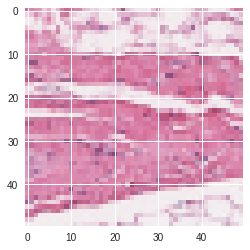

In [0]:
# print one sample of the data
imageList = glob(data_dir + '/**/*.png', recursive=True)
print ( "Number of images: {}". format (len (imageList)))
for img in imageList[0:5]:
    print(img)
    
%matplotlib inline
pil_im = Image.open(imageList[0], 'r')
imshow(np.asarray(pil_im))

**Print a grid of images**

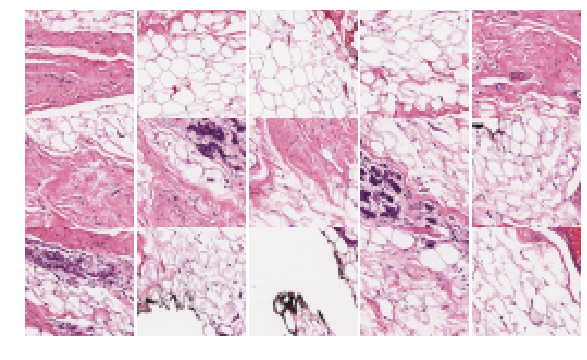

In [0]:
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in imageList[:15]:
    pil_im = Image.open(l, 'r')        
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(np.asarray(pil_im)); 
    plt.axis('off')
    i_ += 1

In [0]:

import os
import fnmatch
import os, sys, pdb, shutil, time, random
import argparse
import torch
import torch.backends.cudnn as cudnn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random
import sys

class GenericDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0]  # file name
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels = self.labels.iloc[idx, 2]  # category_id
        #         print (labels)
        if self.transform:
            image = self.transform(image)
        return image, labels
  
    
    @staticmethod
    def find_classes_breast(fullDir):
        
        imageList = glob(fullDir + '/**/*.png', recursive=True)

        benign = '*class0.png'
        malignant = '*class1.png'
        classZero = fnmatch.filter(imageList, benign)
        classOne = fnmatch.filter(imageList, malignant)
#         print("benign:",classZero[0:5],'\n')
#         print("malignant:",classOne[0:5])
        
        class_to_idx= {'benign': 0, 'malignant': 1}
        num_to_class= {0: 'benign', 1: 'malignant'}
        classes= ['benign', 'malignant']
        
        print('Classes: {}'.format(classes))
        print('class_to_idx: {}'.format(class_to_idx))
        print('num_to_class: {}'.format(num_to_class))

        train = []
        for currImage_on_disk in classZero:
             if os.path.isfile(currImage_on_disk):                
                train.append(['{}'.format(currImage_on_disk), 'benign', class_to_idx['benign']])

        for currImage_on_disk in classOne:
             if os.path.isfile(currImage_on_disk):                
                train.append(['{}'.format(currImage_on_disk), 'malignant', class_to_idx['malignant']])        
                    
        df = pd.DataFrame(train, columns=['file', 'category', 'category_id', ])
        df.to_csv('full_labels_breast.csv', index=None)
        return classes, class_to_idx, num_to_class, df




In [0]:
# show classes
classes, class_to_idx, num_to_class, df =GenericDataset.find_classes_breast (data_dir)

print (classes)
print (class_to_idx)
print (num_to_class)
df.head(5)    

Classes: ['benign', 'malignant']
class_to_idx: {'benign': 0, 'malignant': 1}
num_to_class: {0: 'benign', 1: 'malignant'}
['benign', 'malignant']
{'benign': 0, 'malignant': 1}
{0: 'benign', 1: 'malignant'}


,file,category,category_id
0,/content/drive/applied-dl-2018/db/data/IDC_reg...,benign,0
1,/content/drive/applied-dl-2018/db/data/IDC_reg...,benign,0
2,/content/drive/applied-dl-2018/db/data/IDC_reg...,benign,0
3,/content/drive/applied-dl-2018/db/data/IDC_reg...,benign,0
4,/content/drive/applied-dl-2018/db/data/IDC_reg...,benign,0


In [0]:
len(classes)

2

**Target distribution : Train set**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


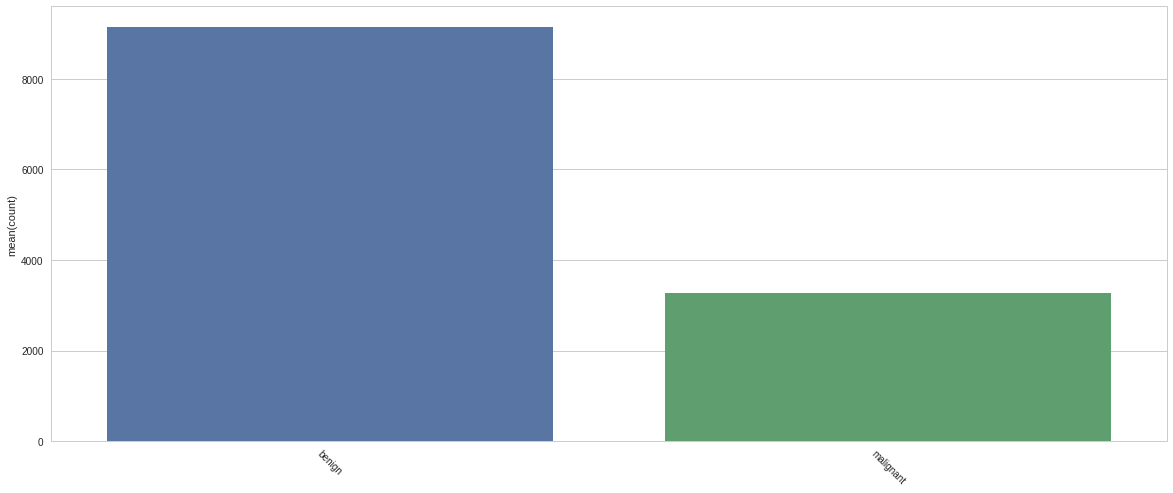

In [0]:
# visualize classes
import seaborn as sns
sns.set(color_codes=True)
pal = sns.color_palette()
sns.set_style("whitegrid")

labels = df['category'].apply(lambda x: [x])
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(20,8)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-45);

**Target distribution : Train set**

In [0]:
# imports
from __future__ import absolute_import

from torchvision.transforms import *

from PIL import Image, ImageDraw
import numpy as np
import torch

import torchvision
import random
from PIL import Image, ImageOps
import numpy as np
import numbers
import math
import torch
import torch
import random
import PIL.ImageEnhance as ie
import PIL.Image as im

# adapted from https://github.com/kuangliu/pytorch-retinanet/blob/master/transform.py
# https://github.com/mratsim/Amazon-Forest-Computer-Vision/blob/master/src/p_data_augmentation.py

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

from ktransforms import *

**Setup transforms, datasets, and dataloaders**


*   Data loaders spit out data from a dataset in batches. This is what you actually feed the neural network during training.



{'train': 2111, 'valid': 372, 'test': 9930}
0    1588
1     523
Name: category_id, dtype: int64


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


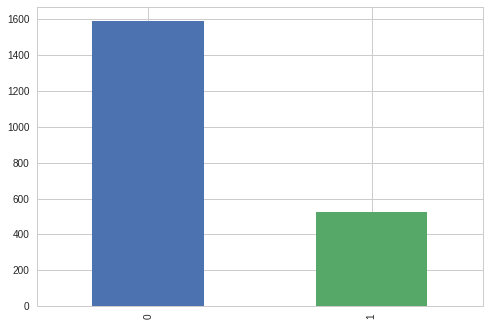

In [0]:
image_size = 224

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


train_trans = transforms.Compose([
    transforms.RandomSizedCrop(image_size),
    PowerPIL(),
    transforms.ToTensor(),
#     normalize_img,
    RandomErasing()
])

## Normalization only for validation and test
valid_trans = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
#     normalize_img
])

batch_size = 16


full_data = df.sample(frac=0.20) # save for testing (not validation)
# full_data = full_data.sample(frac=0.10) # DATA SET IS VERY LARGE use a sample

test_data = df[~df['file'].isin(full_data['file'])]
test_set = GenericDataset(test_data, data_dir, transform = valid_trans)

# Train validation split
train_data = full_data.sample(frac=0.85)
valid_data = full_data[~full_data['file'].isin(train_data['file'])]
train_set = GenericDataset(train_data, data_dir, transform = train_trans)
valid_set = GenericDataset(valid_data, data_dir, transform = valid_trans)
        

t_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
v_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

dataset_sizes = {
    'train': len(t_loader.dataset), 
    'valid': len(v_loader.dataset),
    'test': len(test_loader.dataset)
}


print (dataset_sizes)
print (train_data["category_id"].value_counts())

train_data['category_id'].value_counts().plot(kind='bar')

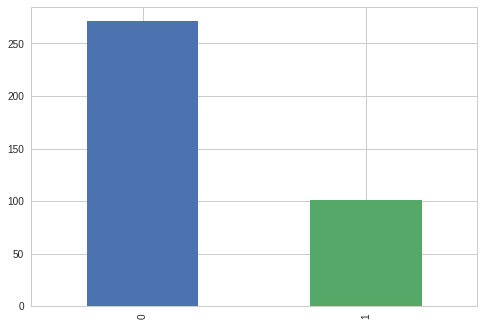

In [0]:
valid_data['category_id'].value_counts().plot(kind='bar')

**Test the DataLoader Class**

i=0: 
i=1: 
i=2: 
i=3: 


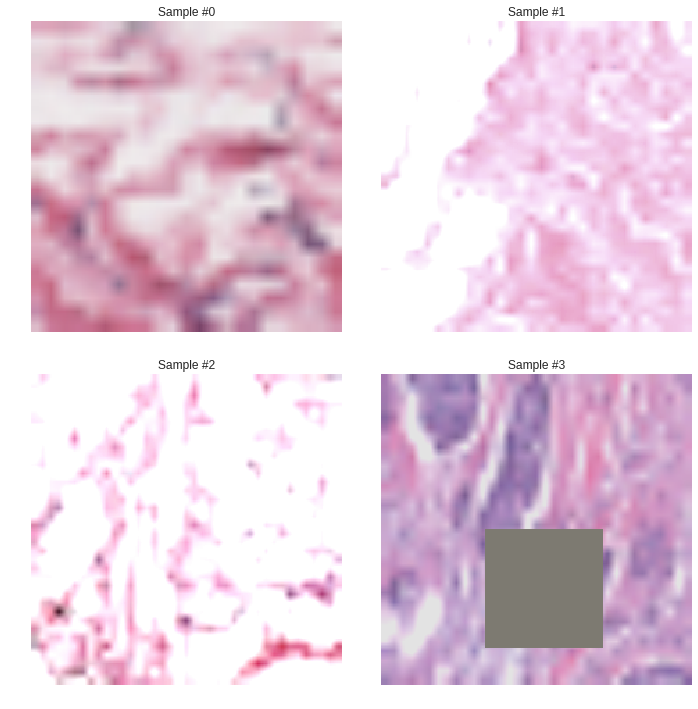

In [0]:
imagesToShow=4

def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    
    

plt.figure(figsize=[10,10])
# if __name__ == '__main__':  
for i, data in enumerate(t_loader, 0):
    print('i=%d: '%(i))            
    images, labels = data            
    num = len(images)

    ax = plt.subplot(2,2, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')

    for n in range(num):
        image=images[n]
        label=labels[n]
        plt.imshow (flaotTensorToImage(image))

    if i==imagesToShow-1:
        break            

**Define the model**


*   A simple CNN with great performance (95% accuracy)
*   In PyTorch, a model is defined by a subclass of nn.Module. It has two methods:

__init__: constructor. Create layers here. Note that we don't define the connections between layers in this function.

forward(x): forward function. Receives an input variable x. Returns a output variable. Note that we actually connect the layers here dynamically.


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np

model = SimpleNet(len(classes), 3)
# model =vggnetXX_generic(len(classes), 3)
# model =lenetXX_generic(len(classes), 3)
# model =resnetxtXX_generic(len(classes), 3)
# model =wrnXX_generic(len(classes), 3)
# model =dpn92(len(classes))
# model = senetXX_generic(len(classes), 3, 32)


criterion = torch.nn.CrossEntropyLoss()
lr= 0.00005 * 2 * 2
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

if use_cuda:
    model = model.cuda()
# model = senetXX_generic(len(classes), 3, 32)
model_name = (type(model).__name__) # remember the real name
# model = torch.nn.DataParallel(model, device_ids=list(range(4)))
print(model)

SimpleNet(
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (cnn1): ConvCNN(
    (math): Sequential(
      (0): Conv2d (3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU(0.01)
      (3): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), dilation=(1, 1))
    )
    (avgpool): AvgPool2d(kernel_size=4, stride=4, padding=0, ceil_mode=False, count_include_pad=True)
  )
  (cnn2): ConvCNN(
    (math): Sequential(
      (0): Conv2d (64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU(0.01)
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
  )
  (cnn3): ConvCNN(
    (math): Sequential(
      (0): Conv2d (64, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(512

**Metrics and Tensorboard**

In [0]:
import datetime 

from utils import *

NOW_TIME = datetime.datetime.now()
NOW_TIME =NOW_TIME.strftime("%Y-%m-%d %H:%M")

use_tensorboard=False

hms_string(1000)

'0:16:40.00'

**Training**

In [0]:
from tqdm import tqdm 
from sklearn import metrics
import torch
import numpy as np
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc

def train(train_loader, model, epoch, optimizer):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()
   
    # switch to train mode
    model.train()

    end = time.time()
    for batch_idx, (images, target) in enumerate(train_loader): 
        correct = 0
        # measure data loading time
        data_time.update(time.time() - end)

        if use_cuda:
            images, target = images.cuda(), target.cuda()
            images, target = Variable(images), Variable(target)
        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, target)

        # measure accuracy and record loss
        prec1, prec1 = accuracy2(y_pred.data, target.data, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))
        
        pred = y_pred.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        accuracy = 100. * correct / len(images)
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % 1000  == 0:
            print('TRAIN: LOSS-->{loss.val:.4f} ({loss.avg:.4f})\t' 'ACC-->{acc.val:.3f}% ({acc.avg:.3f}%)'.format(loss=losses, acc=acc))
            if use_tensorboard:
                exp.add_scalar_value('tr_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('tr_epoch_acc', acc.avg, step=epoch)
                
            print('TRAIN: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {}/{} ({:.3f}%)'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0],
                correct, len(images),
                accuracy))            
    

    return float('{loss.avg:.4f}'.format(loss=losses)), float('{acc.avg:.4f}'.format(acc=acc))

def validate(val_loader, model, epoch):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (images, labels) in enumerate(val_loader):

        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            images, labels = Variable(images, volatile=True), Variable(labels)

        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # measure accuracy and record loss
        prec1, temp_var = accuracy2(y_pred.data, labels.data, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 1000== 0:
            print('VAL:   LOSS--> {loss.val:.4f} ({loss.avg:.4f})\t''ACC-->{acc.val:.3f} ({acc.avg:.3f})'.format(loss=losses, acc=acc))

        if i % 50 == 0:
            if use_tensorboard:
                exp.add_scalar_value('val_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('val_epoch_acc', acc.avg, step=epoch)

    print(' * Accuracy {acc.avg:.4f}'.format(acc=acc))
    return float('{loss.avg:.6f}'.format(loss=losses)), float('{acc.avg:.6f}'.format(acc=acc))


def testImageLoader(image_name):
    """load image, returns cuda tensor"""
#     image = Image.open(image_name)
    image = Image.open(image_name).convert('RGB')
    image = test_trans(image)
#     image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  
    if use_cuda:
#         print ("cuda")
        image.cuda()         
    return image  

def testModel(test_dir, local_model):    
    if use_cuda:
        local_model.cuda()
    
    local_model.eval()
    
    columns = ['file', 'species']
    df_pred = pd.DataFrame(data=np.zeros((0, len(columns))), columns=columns)
#     df_pred.species.astype(int)
    for index, row in (sample_submission.iterrows()):
#         for file in os.listdir(test_dir):            
        currImage=os.path.join(test_dir, row['file'])
        if os.path.isfile(currImage):
            X_tensor_test=testImageLoader (currImage)            
#             print (type(X_tensor_test))
            if use_cuda:
                X_tensor_test = Variable(X_tensor_test.cuda()) 
            else:
                X_tensor_test = Variable(X_tensor_test)        
            
            # get the index of the max log-probability
            predicted_val = (local_model(X_tensor_test)).data.max(1)[1] # get the index of the max log-probability
#             predicted_val = predicted_val.data.max(1, keepdim=True)[1]
            p_test = (predicted_val.cpu().numpy().item())
            df_pred = df_pred.append({'file': row['file'], 'species': num_to_class[int(p_test)]}, ignore_index=True)             
    
    return df_pred

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**Train the model**

In [0]:
if __name__ == '__main__':  
    epochs=20
    runId = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')    
    recorder = RecorderMeter(epochs)  # epoc is updated
#     model_name = (type(model).__name__)

    exp_name = datetime.datetime.now().strftime(model_name + '_' + dataset + '_%Y-%m-%d_%H-%M-%S')    
    mPath = './logs' + '/' + dataset + '/' + model_name + '/'    
    if not os.path.isdir(mPath):
        os.makedirs(mPath)    
    print("Random Seed: {}".format(manualSeed))
    print("python version : {}".format(sys.version.replace('\n', ' ')))
    print("torch  version : {}".format(torch.__version__))
    print("cudnn  version : {}".format(torch.backends.cudnn.version()))    
    print("=> Final model name '{}'".format(model_name))            
    print ("MODEL: {}".format( str(model_name)))
    print ("dataset: {}".format(dataset))
    print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))    
    
    print ("MODEL: {}".format( str(type(model).__name__)))
    
    start_training_time = time.time()
    training_time=time.time()
    for epoch in tqdm(range(0, epochs)):        
        train_result, accuracy_tr=train(t_loader, model, epoch, optimizer)
        val_loss, val_accuracy= validate(v_loader, model, epoch)  
        
        recorder.update(epoch, train_result, accuracy_tr, val_loss, val_accuracy) 
        training_time=time.time() - start_training_time
        recorder.plot_curve(os.path.join(mPath, model_name + '_' + exp_name + '.png'),training_time, model, model_name,
                            str(dataset_sizes),
                        batch_size, lr,dataset,manualSeed,len(classes))
        
        if float(val_accuracy) > float(90.0):            
            print ("EARLY STOP")                        
            torch.save(model.state_dict(), os.path.join(mPath, model_name + '_' + runId + '_' + str(val_accuracy) + '_.pth'))                        

  0%|          | 0/20 [00:00<?, ?it/s]

Random Seed: 999
python version : 3.6.3 (default, Oct  3 2017, 21:45:48)  [GCC 7.2.0]
torch  version : 0.3.0.post4
cudnn  version : 7003
=> Final model name 'SimpleNet'
MODEL: SimpleNet
dataset: IDC_regular_ps50_idx5
    Total params: 1.07M
MODEL: SimpleNet
TRAIN: LOSS-->0.5901 (0.5901)	ACC-->68.750% (68.750%)
TRAIN: 0 [0/2111 (0%)]	Loss: 0.590139, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.5543 (0.5543)	ACC-->81.250 (81.250)
 * Accuracy 81.1828


  5%|▌         | 1/20 [00:37<11:48, 37.29s/it]

TRAIN: LOSS-->0.4459 (0.4459)	ACC-->75.000% (75.000%)
TRAIN: 1 [0/2111 (0%)]	Loss: 0.445907, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.7937 (0.7937)	ACC-->43.750 (43.750)
 * Accuracy 76.6129


 10%|█         | 2/20 [01:13<10:58, 36.58s/it]

TRAIN: LOSS-->0.2131 (0.2131)	ACC-->93.750% (93.750%)
TRAIN: 2 [0/2111 (0%)]	Loss: 0.213107, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.4071 (0.4071)	ACC-->87.500 (87.500)
 * Accuracy 81.7204


 15%|█▌        | 3/20 [01:49<10:19, 36.47s/it]

TRAIN: LOSS-->0.3921 (0.3921)	ACC-->68.750% (68.750%)
TRAIN: 3 [0/2111 (0%)]	Loss: 0.392084, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.2721 (0.2721)	ACC-->93.750 (93.750)
 * Accuracy 81.7204


 20%|██        | 4/20 [02:25<09:42, 36.42s/it]

TRAIN: LOSS-->0.2222 (0.2222)	ACC-->100.000% (100.000%)
TRAIN: 4 [0/2111 (0%)]	Loss: 0.222246, Accuracy: 16/16 (100.000%)
VAL:   LOSS--> 0.4216 (0.4216)	ACC-->75.000 (75.000)
 * Accuracy 83.6022


 25%|██▌       | 5/20 [03:01<09:03, 36.24s/it]

TRAIN: LOSS-->0.2055 (0.2055)	ACC-->93.750% (93.750%)
TRAIN: 5 [0/2111 (0%)]	Loss: 0.205532, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.1988 (0.1988)	ACC-->93.750 (93.750)
 * Accuracy 82.2581


 30%|███       | 6/20 [03:37<08:27, 36.23s/it]

TRAIN: LOSS-->0.4759 (0.4759)	ACC-->75.000% (75.000%)
TRAIN: 6 [0/2111 (0%)]	Loss: 0.475938, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.5081 (0.5081)	ACC-->81.250 (81.250)
 * Accuracy 79.3011


 35%|███▌      | 7/20 [04:13<07:49, 36.15s/it]

TRAIN: LOSS-->0.3465 (0.3465)	ACC-->81.250% (81.250%)
TRAIN: 7 [0/2111 (0%)]	Loss: 0.346454, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.3044 (0.3044)	ACC-->93.750 (93.750)
 * Accuracy 82.5269


 40%|████      | 8/20 [04:52<07:19, 36.62s/it]

TRAIN: LOSS-->0.3355 (0.3355)	ACC-->81.250% (81.250%)
TRAIN: 8 [0/2111 (0%)]	Loss: 0.335472, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1554 (0.1554)	ACC-->100.000 (100.000)
 * Accuracy 78.7634


 45%|████▌     | 9/20 [05:29<06:42, 36.62s/it]

TRAIN: LOSS-->0.2614 (0.2614)	ACC-->100.000% (100.000%)
TRAIN: 9 [0/2111 (0%)]	Loss: 0.261358, Accuracy: 16/16 (100.000%)
VAL:   LOSS--> 0.2806 (0.2806)	ACC-->87.500 (87.500)
 * Accuracy 83.0645


 50%|█████     | 10/20 [06:05<06:05, 36.55s/it]

TRAIN: LOSS-->0.3952 (0.3952)	ACC-->68.750% (68.750%)
TRAIN: 10 [0/2111 (0%)]	Loss: 0.395203, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.4250 (0.4250)	ACC-->87.500 (87.500)
 * Accuracy 83.3333


 55%|█████▌    | 11/20 [06:42<05:29, 36.56s/it]

TRAIN: LOSS-->0.3002 (0.3002)	ACC-->81.250% (81.250%)
TRAIN: 11 [0/2111 (0%)]	Loss: 0.300185, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.6231 (0.6231)	ACC-->62.500 (62.500)
 * Accuracy 83.3333


 60%|██████    | 12/20 [07:18<04:52, 36.51s/it]

TRAIN: LOSS-->0.4021 (0.4021)	ACC-->75.000% (75.000%)
TRAIN: 12 [0/2111 (0%)]	Loss: 0.402113, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.3255 (0.3255)	ACC-->81.250 (81.250)
 * Accuracy 81.1828


 65%|██████▌   | 13/20 [07:54<04:15, 36.51s/it]

TRAIN: LOSS-->0.3706 (0.3706)	ACC-->87.500% (87.500%)
TRAIN: 13 [0/2111 (0%)]	Loss: 0.370592, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.8127 (0.8127)	ACC-->37.500 (37.500)
 * Accuracy 46.5054


 70%|███████   | 14/20 [08:31<03:39, 36.53s/it]

TRAIN: LOSS-->0.3758 (0.3758)	ACC-->81.250% (81.250%)
TRAIN: 14 [0/2111 (0%)]	Loss: 0.375757, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2220 (0.2220)	ACC-->93.750 (93.750)
 * Accuracy 83.6022


 75%|███████▌  | 15/20 [09:07<03:02, 36.48s/it]

TRAIN: LOSS-->0.4977 (0.4977)	ACC-->81.250% (81.250%)
TRAIN: 15 [0/2111 (0%)]	Loss: 0.497733, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.4774 (0.4774)	ACC-->75.000 (75.000)
 * Accuracy 84.1398


 80%|████████  | 16/20 [09:43<02:25, 36.48s/it]

TRAIN: LOSS-->0.3256 (0.3256)	ACC-->81.250% (81.250%)
TRAIN: 16 [0/2111 (0%)]	Loss: 0.325575, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1516 (0.1516)	ACC-->93.750 (93.750)
 * Accuracy 79.5699


 85%|████████▌ | 17/20 [10:19<01:49, 36.43s/it]

TRAIN: LOSS-->0.2592 (0.2592)	ACC-->87.500% (87.500%)
TRAIN: 17 [0/2111 (0%)]	Loss: 0.259185, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.4773 (0.4773)	ACC-->81.250 (81.250)
 * Accuracy 83.3333


 90%|█████████ | 18/20 [10:55<01:12, 36.44s/it]

TRAIN: LOSS-->0.3891 (0.3891)	ACC-->62.500% (62.500%)
TRAIN: 18 [0/2111 (0%)]	Loss: 0.389107, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.2041 (0.2041)	ACC-->93.750 (93.750)
 * Accuracy 85.2151


 95%|█████████▌| 19/20 [11:32<00:36, 36.46s/it]

TRAIN: LOSS-->0.3437 (0.3437)	ACC-->87.500% (87.500%)
TRAIN: 19 [0/2111 (0%)]	Loss: 0.343699, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.4922 (0.4922)	ACC-->75.000 (75.000)
 * Accuracy 77.1505


100%|██████████| 20/20 [12:08<00:00, 36.43s/it]


In [0]:
torch.save(model.state_dict(), os.path.join(mPath, model_name + '_' + runId + '_' + str(val_accuracy) + 'FINAL_.pth'))

In this step, participants will be asked to provide the following classification rates:

-- TP (True Positive, which is the number of OP people correctly identified),

-- FP (False Positive, which is the number of CT people incorrectly identified),

-- TN (True Negative, which is the number of CT people correctly identified),

-- FN (False Negative, which is the number of OP people incorrectly identified),

-- Sn (True positive rate or sensitivity) as Sn = TP/(TP + FN),

-- Sp (Specificity or True Negative Rate) as Sp = TN/(FP + TN).


**Confusion matrix code, from the scikit documentation**

In [0]:
import itertools

# Performance monitoring
from time import process_time
import matplotlib.pyplot as plt
import numpy as np
# %matplotlib nbagg
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def confusion_diagnostic(model, confusion_loader) :
    "Displays a synthetic matrix, which represents our classifier performances."
    y_test    = [] ; y_pred    = [] ; 
    for data, target in confusion_loader: # We won't load the testing dataset all at once:
        # Load the data on the GPU if needed, and wrap it into an autodiff object ----
        if use_cuda: data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        # Evaluation of our model on the test mini-batch -----------------------------
        output     = model(data) # Forward pass through the model
        pred       = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        y_test.append(target.data.cpu().numpy()) ; y_pred.append(pred.view(-1).cpu().numpy())
    y_test = np.hstack(y_test) ; y_pred = np.hstack(y_pred)
    
    # Display --------------------------------------------------------------------   
    cnf_matrix = confusion_matrix(y_test, y_pred)
    fig = plt.figure(dpi=150)
    plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix')
    fig.canvas.draw()

**Confusion matrix on the VALIDATION set**

Normalized confusion matrix


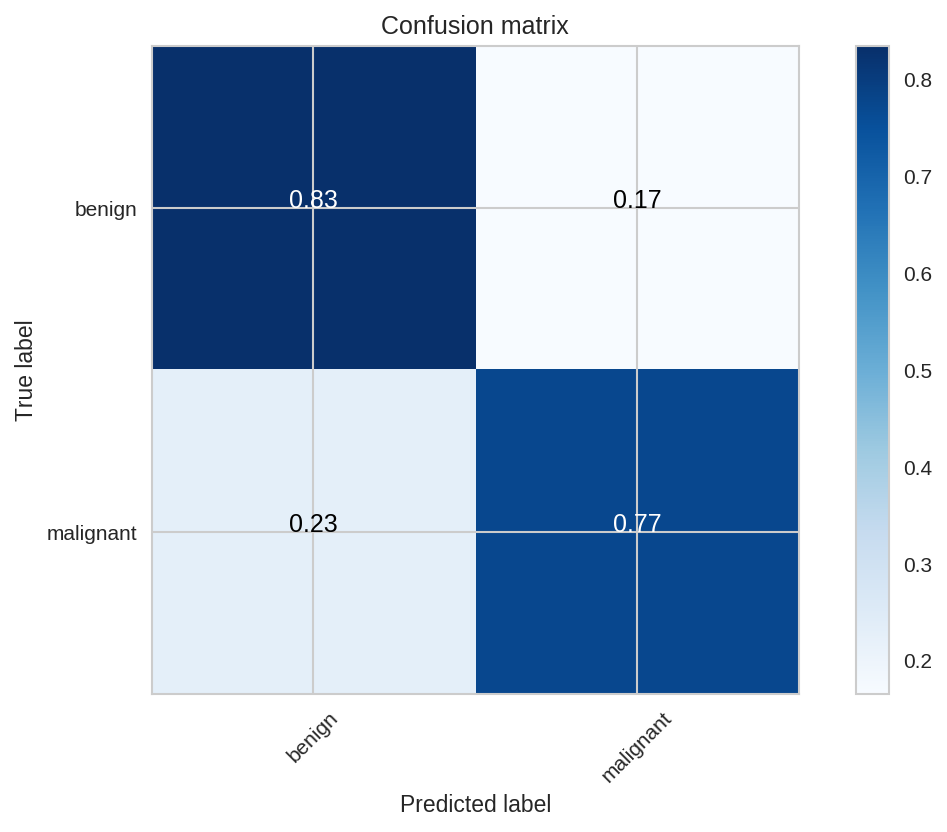

In [0]:
confusion_diagnostic(model, v_loader)

**Confusion matrix on the TEST set**

In [0]:
confusion_diagnostic(model, test_loader)